###### Imports and settings

In [4]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)

###### Read in File  
Ensure everything is consistent from when writing it out in data prep notebook and it is ready for scikitlearn package.

In [5]:
df = gpd.read_file('../data/geo/TN.shp')

In [6]:
df.head()

,GEOID,NAME,NAMELSAD,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,CSA,14permits,19permits,permreal,perm%,geometry
0,4731490,Gruetli-Laager,Gruetli-Laager city,12.68,47,31490,2035,1646,2429,3.25,31.3,47.57,783,19.36,394,Tennessee,191.56,129.81,160.49,61.75,47.57,31.07,19.36,Gruetli-Laager,99999,999,0.0,0.0,0.0,NaN,"POLYGON ((-85.70419 35.37807, -85.70386 35.377..."
1,4722180,Dyer,Dyer city,2.29,47,22180,2744,2335,2791,2.54,27.9,19.53,456,1.71,47,Tennessee,1218.78,1019.65,1198.25,199.13,19.53,20.53,1.71,Dyer,27180,297,1.8,4.8,3.0,166.67,"POLYGON ((-89.00927 36.06839, -89.00926 36.069..."
2,4769320,Smithville,Smithville city,5.85,47,69320,4304,4587,4711,2.76,25.4,2.70,124,9.46,407,Tennessee,805.30,784.10,735.73,21.20,2.70,69.57,9.46,Smithville,99999,999,6.0,20.2,14.2,236.67,"POLYGON ((-85.85567 35.96583, -85.85408 35.965..."
3,4780200,White House,White House city,11.21,47,80200,9567,10618,11843,2.73,35.6,11.54,1225,23.79,2276,Tennessee,1056.47,947.19,853.43,109.28,11.54,203.04,23.79,White House,34980,400,46.6,142.2,95.6,205.15,"MULTIPOLYGON (((-86.71205 36.48038, -86.71164 ..."
4,4737600,Jacksboro,Jacksboro town,2.58,47,37600,1934,1917,2244,2.18,28.7,17.06,327,16.03,310,Tennessee,869.77,743.02,749.61,126.75,17.06,120.16,16.03,Jacksboro town,28940,314,2.2,5.4,3.2,145.45,"POLYGON ((-84.21129 36.33865, -84.20890 36.340..."


In [7]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       105 non-null    object  
 1   NAME        105 non-null    object  
 2   NAMELSAD    105 non-null    object  
 3   SQMILES     105 non-null    float64 
 4   StateFIPS   105 non-null    object  
 5   PlaceFIPS   105 non-null    object  
 6   09pop       105 non-null    int64   
 7   14pop       105 non-null    int64   
 8   19pop       105 non-null    int64   
 9   hhsize      105 non-null    float64 
 10  drive       105 non-null    float64 
 11  ST%         105 non-null    float64 
 12  ST          105 non-null    int64   
 13  LT%         105 non-null    float64 
 14  LT          105 non-null    int64   
 15  State       105 non-null    object  
 16  19density   105 non-null    float64 
 17  14density   105 non-null    float64 
 18  09density   105 non-null    float64 
 19  

Looks good. This is an index-ordered dataframe with multiple numeric columns containing no null or zero values, perfect for scikit learn and its k means clustering algorithm.

# Cluster Analyses

## 1. Variables:  

#### Step One: Set variables.

In [8]:
variables = df[['19pop','LT','LT%','LT%Density','ST%Density','19density','ST','ST%','hhsize','drive','permreal','14permits','19permits']]

#### Step Two: Use the elbow method to determine the proper number of clusters.  

This identifies the value of *k* where the distortion begins to decrease the most rapidly - this becomes clear when plotting the distortion for different values.

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


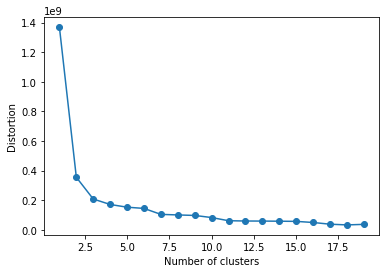

In [9]:
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(variables)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Observations: It looks like the distortion really starts to go down when you reach 8 clusters.

#### Step Three: Implement KMeans algorithm.  

Here you set the clusters to the number identified using the elbow method, and set parameters for the algorithm as outlined below.

In [10]:
km = KMeans(n_clusters = 8, #number of clusters
           init = 'k-means++', #k means ++ is a weighted method of choosing the first datapoint from which to start finding centroids from, versus choosing a random one
           n_init = 10, #run the k-means clustering algorithm 10x independently with random centroids to choose final model w/lowest SSE
           max_iter = 300, #maximum number of iterations for each single run, the implementation in scikit learn stops early if it converges before
           tol = 1e-04, #tolerance for changes in the within-cluster sum-squared error to declare convergence
           random_state = None)

#### Step Four: Use fit_predict to compute cluster centers and predict cluster index per each sample.

In [11]:
y_km = km.fit_predict(variables)
y_km

array([0, 0, 7, 1, 0, 6, 6, 5, 4, 4, 4, 4, 0, 4, 5, 0, 7, 0, 0, 0, 4, 4,
       2, 0, 4, 5, 0, 7, 5, 4, 0, 5, 7, 0, 5, 2, 4, 0, 4, 4, 4, 2, 7, 4,
       4, 4, 4, 0, 4, 4, 0, 7, 1, 3, 0, 4, 4, 5, 4, 0, 0, 0, 5, 4, 0, 2,
       0, 7, 0, 7, 4, 7, 4, 4, 0, 0, 4, 4, 4, 4, 0, 7, 4, 3, 3, 0, 2, 1,
       0, 5, 7, 2, 7, 0, 6, 4, 0, 3, 0, 4, 0, 4, 0, 4, 0])

In [12]:
#See how many instances there are of each cluster id, there are five clusters so 4+1
count_arr = np.bincount(y_km)
for i in range(0, 7+1):
    print('Total occurences of {} in array: '.format(i), count_arr[i-1])

Total occurences of 0 in array:  12
Total occurences of 1 in array:  33
Total occurences of 2 in array:  3
Total occurences of 3 in array:  6
Total occurences of 4 in array:  4
Total occurences of 5 in array:  35
Total occurences of 6 in array:  9
Total occurences of 7 in array:  3


#### Step Five: Assign cluster index as a new row to the df.

In [13]:
df['cluster'] = y_km

#### Step Seven: Identify Coopertown's cluster id.

In [14]:
CT = df.loc[df['GEOID'] == '4716980']
CT

,GEOID,NAME,NAMELSAD,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,CSA,14permits,19permits,permreal,perm%,geometry,cluster
42,4716980,Coopertown,Coopertown town,31.58,47,16980,3342,4321,4496,2.79,33.8,4.05,175,34.53,1154,Tennessee,142.37,136.83,105.83,5.54,4.05,36.54,34.53,Coopertown town,34980,400,6.0,21.8,15.8,263.33,"POLYGON ((-87.03813 36.40682, -87.03807 36.407...",7


#### Step Eight: Create a new dataframe with only peers based on this cluster id and examine.

In [15]:
CTCluster = df.loc[df['cluster'] == 7].reset_index(drop = True)
CTCluster.head(50)

,GEOID,NAME,NAMELSAD,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,CSA,14permits,19permits,permreal,perm%,geometry,cluster
0,4769320,Smithville,Smithville city,5.85,47,69320,4304,4587,4711,2.76,25.4,2.70,124,9.46,407,Tennessee,805.30,784.10,735.73,21.20,2.70,69.57,9.46,Smithville,99999,999,6.0,20.2,14.2,236.67,"POLYGON ((-85.85567 35.96583, -85.85408 35.965...",7
1,4740160,Lafayette,Lafayette city,5.23,47,40160,4334,4731,5171,2.44,27.2,9.30,440,19.31,837,Tennessee,988.72,904.59,828.68,84.13,9.30,160.04,19.31,Lafayette,34980,400,35.6,25.6,-10.0,-28.09,"POLYGON ((-86.07064 36.51292, -86.07059 36.513...",7
2,4755800,Oliver Springs,Oliver Springs town,5.77,47,55800,3213,3063,4468,2.76,25.0,45.87,1405,39.06,1255,Tennessee,774.35,530.85,556.85,243.50,45.87,217.50,39.06,Oliver Springs,28940,314,4.8,1.8,-3.0,-62.50,"POLYGON ((-84.36676 36.03905, -84.36670 36.039...",7
3,4751080,Mount Pleasant,Mount Pleasant city,12.58,47,51080,4451,4604,4847,2.46,26.5,5.28,243,8.90,396,Tennessee,385.29,365.98,353.82,19.31,5.28,31.47,8.89,Mount Pleasant,34980,400,3.0,9.2,6.2,206.67,"POLYGON ((-87.23746 35.51959, -87.23707 35.519...",7
4,4716980,Coopertown,Coopertown town,31.58,47,16980,3342,4321,4496,2.79,33.8,4.05,175,34.53,1154,Tennessee,142.37,136.83,105.83,5.54,4.05,36.54,34.53,Coopertown town,34980,400,6.0,21.8,15.8,263.33,"POLYGON ((-87.03813 36.40682, -87.03807 36.407...",7
5,4747000,Medina,Medina city,4.01,47,47000,2336,3852,4209,2.82,23.4,9.27,357,80.18,1873,Tennessee,1049.63,960.60,582.54,89.03,9.27,467.09,80.18,Medina,27180,297,51.6,29.0,-22.6,-43.80,"MULTIPOLYGON (((-88.78754 35.79369, -88.78751 ...",7
6,4764820,Rogersville,Rogersville town,3.76,47,64820,4291,4410,4437,2.43,21.4,0.61,27,3.40,146,Tennessee,1180.05,1172.87,1141.22,7.18,0.61,38.83,3.40,Rogersville town,28700,304,2.0,0.0,-2.0,-100.00,"MULTIPOLYGON (((-82.99434 36.40106, -82.99430 ...",7
7,4759560,Pleasant View,Pleasant View city,12.52,47,59560,3836,4187,4480,2.82,33.5,7.00,293,16.79,644,Tennessee,357.83,334.42,306.39,23.41,7.00,51.44,16.79,Pleasant View,34980,400,11.6,71.8,60.2,518.97,"POLYGON ((-87.10045 36.40264, -87.10031 36.403...",7
8,4779980,White Bluff,White Bluff town,6.07,47,79980,2452,3269,3517,2.69,38.3,7.59,248,43.43,1065,Tennessee,579.41,538.55,403.95,40.86,7.59,175.46,43.44,White Bluff town,34980,400,14.6,31.6,17.0,116.44,"POLYGON ((-87.25353 36.10663, -87.25351 36.106...",7
9,4702180,Ashland City,Ashland City town,10.67,47,02180,4537,4643,4680,2.23,31.5,0.80,37,3.15,143,Tennessee,438.61,435.15,425.21,3.46,0.80,13.40,3.15,Ashland City town,34980,400,1.8,33.8,32.0,1777.78,"POLYGON ((-87.08547 36.28374, -87.08426 36.284...",7


In [16]:
CTCluster.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       12 non-null     object  
 1   NAME        12 non-null     object  
 2   NAMELSAD    12 non-null     object  
 3   SQMILES     12 non-null     float64 
 4   StateFIPS   12 non-null     object  
 5   PlaceFIPS   12 non-null     object  
 6   09pop       12 non-null     int64   
 7   14pop       12 non-null     int64   
 8   19pop       12 non-null     int64   
 9   hhsize      12 non-null     float64 
 10  drive       12 non-null     float64 
 11  ST%         12 non-null     float64 
 12  ST          12 non-null     int64   
 13  LT%         12 non-null     float64 
 14  LT          12 non-null     int64   
 15  State       12 non-null     object  
 16  19density   12 non-null     float64 
 17  14density   12 non-null     float64 
 18  09density   12 non-null     float64 
 19  ST

In [24]:
#write out shapefile to map
df.to_file('../data/geo/TNPLACESCLUSTER.shp')

In [18]:
#drop geometry
final_data_allTNplaces = df.drop(columns = ['geometry'])

In [19]:
#write out all places post parameters with their clusters
final_data_allTNplaces.to_csv('../data/clusters_allTNplaces.csv')

In [20]:
#drop geometry from CT cluster
final_data_CTCluster = CTCluster.drop(columns = ['geometry'])

In [23]:
#write out CT cluster coming from Tennessee places
final_data_CTCluster.to_csv('../data/CTCluster_fromTNplaces.csv')